Note on code structure: Each cell in this notebook is designed to be executed independently to allow different models to be run at different times according to GPU availability.


In [ ]:
!nvidia-smi


Tue Dec 30 18:51:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             27W /   70W |   15092MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# mGPT

In [ ]:
"""
QLoRA (4-bit) + LoRA fine-tuning for multilingual polarization detection

"""

# =========================
# 0) STABILITY SETTINGS
# =========================
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# =========================
# 1) INSTALL DEPENDENCIES
# =========================
!pip -q install -U transformers datasets accelerate evaluate scikit-learn bitsandbytes peft

# =========================
# 2) IMPORTS
# =========================
import glob
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    set_seed,
    DataCollatorWithPadding,
)

from peft import (
    LoraConfig,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
set_seed(42)

# =========================
# 3) UNZIP DATA
# =========================
ZIP_PATH = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if os.path.exists(ZIP_PATH) and not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR = os.path.join(SUBTASK1_DIR, "train")
DEV_DIR   = os.path.join(SUBTASK1_DIR, "dev")  # unlabeled, not used for eval here

# =========================
# 4) LOAD TRAIN DATA (labeled)
# =========================
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = [c.strip() for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    text_col = None
    for c in TEXT_CANDIDATES:
        if c in lower_map:
            text_col = lower_map[c]
            break

    label_col = None
    for c in LABEL_CANDIDATES:
        if c in lower_map:
            label_col = lower_map[c]
            break

    return text_col, label_col

#load one language cvs
def load_csv_labeled(path, lang):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)

    if text_col is None:
        raise ValueError(f"[{lang}] No text column in {path}")
    if label_col is None:
        raise ValueError(f"[{lang}] No label column in {path}")

    out = pd.DataFrame()
    out["text"] = df[text_col].astype(str)

    # assumes labels are numeric 0/1 in train
    out["label"] = pd.to_numeric(df[label_col], errors="raise").astype(int)
    out["label"] = out["label"].clip(0, 1)

    out["lang"] = lang
    return out.dropna(subset=["text"]).reset_index(drop=True)

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
train_langs = [os.path.splitext(os.path.basename(p))[0] for p in train_files]
print(f"Found {len(train_files)} train language files")

train_dfs = []
for lang in train_langs:
    train_path = os.path.join(TRAIN_DIR, f"{lang}.csv")
    train_dfs.append(load_csv_labeled(train_path, lang))

train_df = pd.concat(train_dfs, ignore_index=True)
#use the same random state
#shuffle once to remove any implicit ordering
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(f"Total labeled examples (train folder): {len(train_df)}")
print("Overall label distribution:", train_df["label"].value_counts().to_dict())

# =========================
# 5) SPLIT INTO TRAIN / VAL
# =========================
#dev data has no labels
#so we do internal validation split from train for evaluation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.10,
    random_state=42,
    stratify=train_df["label"]
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("\nSplit summary:")
print("Train size:", len(train_df), "Val size:", len(val_df))
print("Train label dist:", train_df["label"].value_counts().to_dict())
print("Val label dist:", val_df["label"].value_counts().to_dict())

# =========================
# 6) MODEL SETUP: QLoRA + LoRA
# =========================
MODEL_NAME = "ai-forever/mGPT"
MAX_LENGTH = 64  # test this first for Colab GPU

print(f"\nLoading tokenizer: {MODEL_NAME} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
#left padding is safer for decoder only model
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Pad token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)

#4-bit quantization to fit mGPT on limited GPU memory in Colab
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

print(f"Loading model in 4-bit: {MODEL_NAME} ...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification",
    quantization_config=bnb_config,
    device_map="auto",
)

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False  # must be False for training

model = prepare_model_for_kbit_training(model)

#apply lora to attention projection layers
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["c_attn", "c_proj"],
)

model = get_peft_model(model, lora_config)

print("\nTrainable parameters (LoRA only):")
model.print_trainable_parameters()

# =========================
# 7) TOKENIZATION
# =========================
#tokenize text and attach labels for trainer
def preprocess_function(examples):
    enc = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,
    )
    enc["labels"] = examples["label"]
    return enc

hf_train = Dataset.from_pandas(train_df[["text", "label"]], preserve_index=False)
hf_val   = Dataset.from_pandas(val_df[["text", "label"]], preserve_index=False)

tokenized_train = hf_train.map(
    preprocess_function,
    batched=True,
    remove_columns=hf_train.column_names,
    desc="Tokenizing train"
)

tokenized_val = hf_val.map(
    preprocess_function,
    batched=True,
    remove_columns=hf_val.column_names,
    desc="Tokenizing val"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# =========================
# 8) TRAINING ARGUMENTS
# =========================
training_args = TrainingArguments(
    output_dir="./mgpt_polarization_qlora_valsplit",
    learning_rate=2e-4,

    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,   # effective batch 16

    # budgeted training for Colab GPU
    max_steps=1000,
    warmup_ratio=0.06,
    weight_decay=0.0,

    logging_steps=100,
    save_strategy="no", #to save disk usage in Colab

    # we evaluate on our internal val split
    eval_strategy="steps",
    eval_steps=250,

    fp16=True,
    optim="paged_adamw_8bit",
    report_to="none",

    remove_unused_columns=False,
    dataloader_num_workers=0,
)

#macro-f1 is used in this task
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"f1_macro": f1_score(labels, preds, average="macro")}

# =========================
# 9) TRAIN
# =========================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,  # deprecated warning is fine
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n" + "="*50)
print("STARTING TRAINING (QLoRA + internal val split)")
print("="*50)

trainer.train()

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)

# =========================
# 10) FINAL EVALUATION ON VAL
# =========================
print("\n" + "="*50)
print("FINAL EVALUATION ON VAL")
print("="*50)

pred = trainer.predict(tokenized_val)
val_preds = np.argmax(pred.predictions, axis=1)

val_f1 = f1_score(pred.label_ids, val_preds, average="macro")
print(f"VAL Macro F1: {val_f1:.4f}\n")
print(classification_report(pred.label_ids, val_preds, digits=4))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.8 MB/s eta 0:00:00
Torch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Found 22 train language files
Total labeled examples (train folder): 73681
Overall label distribution: {1: 39145, 0: 34536}

Split summary:
Train size: 66312 Val size: 7369
Train label dist: {1: 35230, 0: 31082}
Val label dist: {1: 3915, 0: 3454}

Loading tokenizer: ai-forever/mGPT ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

Pad token: <pad> id: 1
Loading model in 4-bit: ai-forever/mGPT ...


config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/mGPT and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trainable parameters (LoRA only):
trainable params: 4,329,472 || all params: 1,421,930,496 || trainable%: 0.3045


Tokenizing train:   0%|          | 0/66312 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/7369 [00:00<?, ? examples/s]

/tmp/ipython-input-2067241811.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



STARTING TRAINING (QLoRA + internal val split)


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,F1 Macro
250,0.674300,0.616289,0.653275
500,0.631700,0.592613,0.678340
750,0.618800,0.595163,0.671368
1000,0.581100,0.561315,0.704885


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt


TRAINING COMPLETE

FINAL EVALUATION ON VAL


VAL Macro F1: 0.7049

              precision    recall  f1-score   support

           0     0.6727    0.7224    0.6966      3454
           1     0.7380    0.6899    0.7131      3915

    accuracy                         0.7051      7369
   macro avg     0.7053    0.7061    0.7049      7369
weighted avg     0.7074    0.7051    0.7054      7369



In [ ]:
# =========================
# EXPERIMENT 2
# =========================


"""
QLoRA (4-bit) + LoRA fine-tuning for multilingual polarization detection
"""

# =========================
# 0) STABILITY SETTINGS
# =========================
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# =========================
# 1) INSTALL DEPENDENCIES
# =========================
!pip -q install -U transformers datasets accelerate evaluate scikit-learn bitsandbytes peft

# =========================
# 2) IMPORTS
# =========================
import glob
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    set_seed,
    DataCollatorWithPadding,
)

from peft import (
    LoraConfig,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
set_seed(42)

# =========================
# 3) UNZIP DATA
# =========================
ZIP_PATH = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if os.path.exists(ZIP_PATH) and not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR = os.path.join(SUBTASK1_DIR, "train")
DEV_DIR   = os.path.join(SUBTASK1_DIR, "dev")  # unlabeled, not used for eval here

# =========================
# 4) LOAD TRAIN DATA (labeled)
# =========================
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = [c.strip() for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    text_col = None
    for c in TEXT_CANDIDATES:
        if c in lower_map:
            text_col = lower_map[c]
            break

    label_col = None
    for c in LABEL_CANDIDATES:
        if c in lower_map:
            label_col = lower_map[c]
            break

    return text_col, label_col

#load one language cvs
def load_csv_labeled(path, lang):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)

    if text_col is None:
        raise ValueError(f"[{lang}] No text column in {path}")
    if label_col is None:
        raise ValueError(f"[{lang}] No label column in {path}")

    out = pd.DataFrame()
    out["text"] = df[text_col].astype(str)

    # assumes labels are numeric 0/1 in train
    out["label"] = pd.to_numeric(df[label_col], errors="raise").astype(int)
    out["label"] = out["label"].clip(0, 1)

    out["lang"] = lang
    return out.dropna(subset=["text"]).reset_index(drop=True)

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
train_langs = [os.path.splitext(os.path.basename(p))[0] for p in train_files]
print(f"Found {len(train_files)} train language files")

train_dfs = []
for lang in train_langs:
    train_path = os.path.join(TRAIN_DIR, f"{lang}.csv")
    train_dfs.append(load_csv_labeled(train_path, lang))

train_df = pd.concat(train_dfs, ignore_index=True)
#use the same random state
#shuffle once to remove any implicit ordering
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(f"Total labeled examples (train folder): {len(train_df)}")
print("Overall label distribution:", train_df["label"].value_counts().to_dict())

# =========================
# 5) SPLIT INTO TRAIN / VAL (since dev has no labels)
# =========================
#dev data has no labels
#so we do internal validation split from train for evaluation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.10,
    random_state=42,
    stratify=train_df["label"]
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("\nSplit summary:")
print("Train size:", len(train_df), "Val size:", len(val_df))
print("Train label dist:", train_df["label"].value_counts().to_dict())
print("Val label dist:", val_df["label"].value_counts().to_dict())

# =========================
# 6) MODEL SETUP: QLoRA + LoRA
# =========================
MODEL_NAME = "ai-forever/mGPT"
MAX_LENGTH = 128  # CHANGED--------------------------------------------

print(f"\nLoading tokenizer: {MODEL_NAME} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
#left padding is safer for decoder only model
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Pad token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)

#4-bit quantization to fit mGPT on limited GPU memory in Colab
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

print(f"Loading model in 4-bit: {MODEL_NAME} ...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification",
    quantization_config=bnb_config,
    device_map="auto",
)

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False  # must be False for training

model = prepare_model_for_kbit_training(model)

#apply lora to attention projection layers
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["c_attn", "c_proj"],
)

model = get_peft_model(model, lora_config)

print("\nTrainable parameters (LoRA only):")
model.print_trainable_parameters()

# =========================
# 7) TOKENIZATION
# =========================

#tokenize text and attach labels for trainer
def preprocess_function(examples):
    enc = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,
    )
    enc["labels"] = examples["label"]
    return enc

hf_train = Dataset.from_pandas(train_df[["text", "label"]], preserve_index=False)
hf_val   = Dataset.from_pandas(val_df[["text", "label"]], preserve_index=False)

tokenized_train = hf_train.map(
    preprocess_function,
    batched=True,
    remove_columns=hf_train.column_names,
    desc="Tokenizing train"
)

tokenized_val = hf_val.map(
    preprocess_function,
    batched=True,
    remove_columns=hf_val.column_names,
    desc="Tokenizing val"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# =========================
# 8) TRAINING ARGUMENTS
# =========================
training_args = TrainingArguments(
    output_dir="./mgpt_polarization_qlora_valsplit",
    learning_rate=2e-4,

    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,   # effective batch 16

    # max_steps=1000,
    warmup_ratio=0.06,
    weight_decay=0.0,
    num_train_epochs=1,


    logging_steps=500,
    save_strategy="no", #to save disk usage in Colab

    # we evaluate on our internal val split
    eval_strategy="steps",
    eval_steps=500,

    fp16=True,
    optim="paged_adamw_8bit",
    report_to="none",

    remove_unused_columns=False,
    dataloader_num_workers=0,
)

#macro-f1 is used in this task
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"f1_macro": f1_score(labels, preds, average="macro")}

# =========================
# 9) TRAIN
# =========================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n" + "="*50)
print("STARTING TRAINING (QLoRA + internal val split)")
print("="*50)

trainer.train()

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)

# =========================
# 10) FINAL EVALUATION ON VAL
# =========================
print("\n" + "="*50)
print("FINAL EVALUATION ON VAL")
print("="*50)

pred = trainer.predict(tokenized_val)
val_preds = np.argmax(pred.predictions, axis=1)

val_f1 = f1_score(pred.label_ids, val_preds, average="macro")
print(f"VAL Macro F1: {val_f1:.4f}\n")
print(classification_report(pred.label_ids, val_preds, digits=4))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.1 MB/s eta 0:00:00
Torch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Found 22 train language files
Total labeled examples (train folder): 73681
Overall label distribution: {1: 39145, 0: 34536}

Split summary:
Train size: 66312 Val size: 7369
Train label dist: {1: 35230, 0: 31082}
Val label dist: {1: 3915, 0: 3454}

Loading tokenizer: ai-forever/mGPT ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

Pad token: <pad> id: 1
Loading model in 4-bit: ai-forever/mGPT ...


config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/mGPT and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trainable parameters (LoRA only):
trainable params: 4,329,472 || all params: 1,421,930,496 || trainable%: 0.3045


Tokenizing train:   0%|          | 0/66312 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/7369 [00:00<?, ? examples/s]

/tmp/ipython-input-3867677025.py:270: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



STARTING TRAINING (QLoRA + internal val split)


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,F1 Macro
500,0.701700,0.655134,0.572131
1000,0.648900,0.626052,0.585117
1500,0.605600,0.577291,0.699687
2000,0.592600,0.549886,0.713480
2500,0.556700,0.528236,0.730328
3000,0.546700,0.522367,0.731901
3500,0.527300,0.512168,0.747166
4000,0.515100,0.496781,0.753024


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt


TRAINING COMPLETE

FINAL EVALUATION ON VAL


VAL Macro F1: 0.7527

              precision    recall  f1-score   support

           0     0.7621    0.6948    0.7269      3454
           1     0.7502    0.8087    0.7784      3915

    accuracy                         0.7553      7369
   macro avg     0.7562    0.7518    0.7527      7369
weighted avg     0.7558    0.7553    0.7543      7369



# CLSTM

## CLSTM with no class weights

In [ ]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"


In [ ]:
# =========================
# CLSTM
# Binary polarization detection
# =========================

# 0) installs
!pip -q install -U transformers datasets scikit-learn

import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer

# -------------------------
# 1) unzip data
# -------------------------
#don't forget to upload the file
ZIP_PATH  = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Zip not found at {ZIP_PATH}. Upload it to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR    = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print("TRAIN_DIR:", TRAIN_DIR)
print("Found train CSVs:", len(train_files))
#debug: print folder structure if train csvs not found
if len(train_files) == 0:
    print("Available under subtask1:", glob.glob(os.path.join(SUBTASK1_DIR, "*")))
    raise RuntimeError("No train CSVs found. Check zip structure.")

# -------------------------
# 2) load + infer columns
# -------------------------
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = [c.strip() for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    text_col = None
    for c in TEXT_CANDIDATES:
        if c in lower_map:
            text_col = lower_map[c]
            break

    label_col = None
    for c in LABEL_CANDIDATES:
        if c in lower_map:
            label_col = lower_map[c]
            break

    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(
            f"Column inference failed for {os.path.basename(path)}. "
            f"Columns: {list(df.columns)}"
        )
    out = pd.DataFrame()
    out["text"]  = df[text_col].astype(str)
    out["label"] = pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1)
    out["lang"]  = os.path.splitext(os.path.basename(path))[0]
    return out.dropna(subset=["text"]).reset_index(drop=True)

dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total examples:", len(full_df))
print("Label dist:", full_df["label"].value_counts().to_dict())
print("Languages:", full_df["lang"].nunique())

# -------------------------
# 3) train/val split
# -------------------------
#stratified split to preserve class balance in val
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    random_state=42,
    stratify=full_df["label"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))
print("Train dist:", train_df["label"].value_counts().to_dict())
print("Val dist:", val_df["label"].value_counts().to_dict())

# -------------------------
# 4) tokenizer (multilingual) + dataset
# -------------------------
#use mbert tokenizer for multilingual subword ids
MODEL_TOKENIZER = "bert-base-multilingual-cased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_TOKENIZER, use_fast=True)
# ensure pad token exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token is not None else tokenizer.unk_token

#tokenize to fixed length and return input_ids + label
class PolDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    #pad/truncate to max_len for batching
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_ds = PolDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = PolDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)
#dataloaders for training/eval
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

# -------------------------
# 5) CLSTM model (CNN -> LSTM -> Dense)
# -------------------------
#clstm: embedding -> conv1d -> lstm -> classifier
class CLSTM(nn.Module):
    def __init__(self, vocab_size, pad_id, embed_dim=128, cnn_filters=64, kernel_size=3,
                 lstm_hidden=128, dropout=0.3, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.conv = nn.Conv1d(embed_dim, cnn_filters, kernel_size, padding=kernel_size//2)
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=False)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)          # (B,T,E)
        x = x.transpose(1,2)                   # (B,E,T)
        x = torch.relu(self.conv(x))           # (B,C,T)
        x = x.transpose(1,2)                   # (B,T,C)
        _, (h, _) = self.lstm(x)               # h: (1,B,H)
        h = h.squeeze(0)                       # (B,H)
        h = self.drop(h)
        return self.fc(h)                      # (B,2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLSTM(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    embed_dim=128,
    cnn_filters=64,
    kernel_size=3,
    lstm_hidden=128,
    dropout=0.3,
    num_classes=2
).to(device)

# -------------------------
# 6) loss (without class weights) + optimizer
# -------------------------
#unweighted ce loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# -------------------------
# 7) train + eval
# -------------------------
#macro-f1 is the metric used in this task
def eval_macro_f1(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["input_ids"].to(device)
            y = batch["label"].to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    return f1_score(all_labels, all_preds, average="macro"), all_labels, all_preds

EPOCHS = 10
best_f1 = -1.0
best_state = None

#train for fixed epochs, keep best by val macro-f1
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = batch["input_ids"].to(device)
        y = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        #gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    val_f1, _, _ = eval_macro_f1(model, val_loader)
    avg_loss = total_loss / max(1, len(train_loader))
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={avg_loss:.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        #save best model weights (no disk checkpoints)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest VAL Macro F1:", round(best_f1, 4))

# restore best + detailed report
if best_state is not None:
    model.load_state_dict(best_state)

val_f1, y_true, y_pred = eval_macro_f1(model, val_loader)
print(f"\nFINAL VAL Macro F1 (best checkpoint): {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))


TRAIN_DIR: /content/dev_phase/subtask1/train
Found train CSVs: 22
Total examples: 73681
Label dist: {1: 39145, 0: 34536}
Languages: 22
Train: 66312 Val: 7369
Train dist: {1: 35230, 0: 31082}
Val dist: {1: 3915, 0: 3454}


Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.6909 | val_macro_f1=0.3191


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=0.6847 | val_macro_f1=0.6176


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=0.6121 | val_macro_f1=0.7044


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.5115 | val_macro_f1=0.7397


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.4434 | val_macro_f1=0.7471


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.3741 | val_macro_f1=0.7395


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.3132 | val_macro_f1=0.7448


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.2620 | val_macro_f1=0.7436


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.2246 | val_macro_f1=0.7351


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.1968 | val_macro_f1=0.7363

Best VAL Macro F1: 0.7471

FINAL VAL Macro F1 (best checkpoint): 0.7471

              precision    recall  f1-score   support

           0     0.7325    0.7287    0.7306      3454
           1     0.7618    0.7653    0.7635      3915

    accuracy                         0.7481      7369
   macro avg     0.7471    0.7470    0.7471      7369
weighted avg     0.7481    0.7481    0.7481      7369



## CLSTM with class weights

It computes class counts on the training split and sets inverse-frequency like weights.
Minority classes are penalized more.

In [ ]:
# =========================
# CLSTM
# =========================

# 0) installs
!pip -q install -U transformers datasets scikit-learn

import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer

# -------------------------
# 1) unzip data
# -------------------------
#don't forget to upload the file
ZIP_PATH  = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Zip not found at {ZIP_PATH}. Upload it to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR    = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print("TRAIN_DIR:", TRAIN_DIR)
print("Found train CSVs:", len(train_files))
#debug: print folder structure if train csvs not found
if len(train_files) == 0:
    print("Available under subtask1:", glob.glob(os.path.join(SUBTASK1_DIR, "*")))
    raise RuntimeError("No train CSVs found. Check zip structure.")

# -------------------------
# 2) load + infer columns
# -------------------------
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = [c.strip() for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    text_col = None
    for c in TEXT_CANDIDATES:
        if c in lower_map:
            text_col = lower_map[c]
            break

    label_col = None
    for c in LABEL_CANDIDATES:
        if c in lower_map:
            label_col = lower_map[c]
            break

    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(
            f"Column inference failed for {os.path.basename(path)}. "
            f"Columns: {list(df.columns)}"
        )
    out = pd.DataFrame()
    out["text"]  = df[text_col].astype(str)
    out["label"] = pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1)
    out["lang"]  = os.path.splitext(os.path.basename(path))[0]
    return out.dropna(subset=["text"]).reset_index(drop=True)

dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total examples:", len(full_df))
print("Label dist:", full_df["label"].value_counts().to_dict())
print("Languages:", full_df["lang"].nunique())

# -------------------------
# 3) train/val split
# -------------------------
#stratified split to preserve class balance in val
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    random_state=42,
    stratify=full_df["label"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))
print("Train dist:", train_df["label"].value_counts().to_dict())
print("Val dist:", val_df["label"].value_counts().to_dict())

# -------------------------
# 4) tokenizer (multilingual) + dataset
# -------------------------
#use mbert tokenizer for multilingual subword ids
MODEL_TOKENIZER = "bert-base-multilingual-cased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_TOKENIZER, use_fast=True)
# ensure pad token exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token is not None else tokenizer.unk_token

#tokenize to fixed length and return input_ids + label
class PolDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    #pad/truncate to max_len for batching
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_ds = PolDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = PolDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)

#dataloaders for training/eval
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

# -------------------------
# 5) CLSTM model (CNN -> LSTM -> Dense)
# -------------------------
#clstm: embedding -> conv1d -> lstm -> classifier
class CLSTM(nn.Module):
    def __init__(self, vocab_size, pad_id, embed_dim=128, cnn_filters=64, kernel_size=3,
                 lstm_hidden=128, dropout=0.3, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.conv = nn.Conv1d(embed_dim, cnn_filters, kernel_size, padding=kernel_size//2)
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=False)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)          # (B,T,E)
        x = x.transpose(1,2)                   # (B,E,T)
        x = torch.relu(self.conv(x))           # (B,C,T)
        x = x.transpose(1,2)                   # (B,T,C)
        _, (h, _) = self.lstm(x)               # h: (1,B,H)
        h = h.squeeze(0)                       # (B,H)
        h = self.drop(h)
        return self.fc(h)                      # (B,2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLSTM(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    embed_dim=128,
    cnn_filters=64,
    kernel_size=3,
    lstm_hidden=128,
    dropout=0.3,
    num_classes=2
).to(device)

# -------------------------
# 6) loss (with class weights) + optimizer
# -------------------------
#compute weighted loss
counts = train_df["label"].value_counts().to_dict()
n0 = counts.get(0, 1)
n1 = counts.get(1, 1)
w0 = (n0 + n1) / (2.0 * n0)
w1 = (n0 + n1) / (2.0 * n1)
class_weights = torch.tensor([w0, w1], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# -------------------------
# 7) train + eval
# -------------------------
#macro-f1 is the metric used in this task
def eval_macro_f1(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["input_ids"].to(device)
            y = batch["label"].to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    return f1_score(all_labels, all_preds, average="macro"), all_labels, all_preds

EPOCHS = 10
best_f1 = -1.0
best_state = None

#train for fixed epochs, keep best by val macro-f1
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        x = batch["input_ids"].to(device)
        y = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        #gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    val_f1, _, _ = eval_macro_f1(model, val_loader)
    avg_loss = total_loss / max(1, len(train_loader))
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={avg_loss:.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        #save best model weights (no disk checkpoints)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest VAL Macro F1:", round(best_f1, 4))

# restore best + detailed report
if best_state is not None:
    model.load_state_dict(best_state)

val_f1, y_true, y_pred = eval_macro_f1(model, val_loader)
print(f"\nFINAL VAL Macro F1 (best checkpoint): {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))


TRAIN_DIR: /content/dev_phase/subtask1/train
Found train CSVs: 22
Total examples: 73681
Label dist: {1: 39145, 0: 34536}
Languages: 22
Train: 66312 Val: 7369
Train dist: {1: 35230, 0: 31082}
Val dist: {1: 3915, 0: 3454}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Epoch 1/10 | train_loss=0.6935 | val_macro_f1=0.3354
Epoch 2/10 | train_loss=0.6875 | val_macro_f1=0.4357
Epoch 3/10 | train_loss=0.6710 | val_macro_f1=0.6098
Epoch 4/10 | train_loss=0.6392 | val_macro_f1=0.6596
Epoch 5/10 | train_loss=0.5880 | val_macro_f1=0.7017
Epoch 6/10 | train_loss=0.5339 | val_macro_f1=0.6913
Epoch 7/10 | train_loss=0.4847 | val_macro_f1=0.7253
Epoch 8/10 | train_loss=0.4425 | val_macro_f1=0.7399
Epoch 9/10 | train_loss=0.4013 | val_macro_f1=0.7430
Epoch 10/10 | train_loss=0.3644 | val_macro_f1=0.7493

Best VAL Macro F1: 0.7493

FINAL VAL Macro F1 (best checkpoint): 0.7493

              precision    recall  f1-score   support

           0     0.7299    0.7409    0.7353      3454
           1     0.7683    0.7581    0.7632      3915

    accuracy                         0.7500      7369
   macro avg     0.7491    0.7495    0.7493      7369
weighted avg     0.7503    0.7500    0.7501      7369



# BiLSTM

## BiLSTM with no attention

In [ ]:
# =========================
# BiLSTM for multilingual polarization detection
# No class weights
# =========================

#use mbert tokenizer ids as input to our own embedding layer
#internal train/val split because dev is unlabeled

!pip -q install -U transformers scikit-learn

import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer

#avoid torch._dynamo issues in some colab sessions
import os as _os
_os.environ["TORCHDYNAMO_DISABLE"] = "1"
_os.environ["TORCH_COMPILE_DISABLE"] = "1"

# -------------------------
# 1) unzip data
# -------------------------
ZIP_PATH  = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Zip not found at {ZIP_PATH}. Upload it to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR    = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print("TRAIN_DIR:", TRAIN_DIR)
print("Found train CSVs:", len(train_files))
#debug: print folder structure if train csvs not found
if len(train_files) == 0:
    raise RuntimeError("No train CSVs found. Check zip structure.")

# -------------------------
# 2) load + infer columns
# -------------------------
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = [c.strip() for c in df.columns]
    lower_map = {c.lower(): c for c in cols}
    text_col  = next((lower_map[c] for c in TEXT_CANDIDATES  if c in lower_map), None)
    label_col = next((lower_map[c] for c in LABEL_CANDIDATES if c in lower_map), None)
    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(f"Column inference failed for {os.path.basename(path)}. Columns: {list(df.columns)}")
    out = pd.DataFrame()
    out["text"]  = df[text_col].astype(str)
    out["label"] = pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1)
    out["lang"]  = os.path.splitext(os.path.basename(path))[0]
    return out.dropna(subset=["text"]).reset_index(drop=True)

dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total examples:", len(full_df))
print("Label dist:", full_df["label"].value_counts().to_dict())
print("Languages:", full_df["lang"].nunique())

# -------------------------
# 3) train/val split
# -------------------------
#stratified split to preserve class balance similar in train and val
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    random_state=42,
    stratify=full_df["label"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))

# -------------------------
# 4) tokenizer + dataset
# -------------------------
TOKENIZER_NAME = "bert-base-multilingual-cased"
MAX_LEN = 128
BATCH_SIZE = 64

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
#pad token needed because we use padding="max_length"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token

#dataset: tokenize text -> fixed length input_ids -> return label
class PolDataset(Dataset):
    def __init__(self, texts, labels, tok, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tok
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",  #return_tensors="pt" adds batch dim -> squeeze(0) removes it (shape: [max_len])
        )

        #label as long for cross entropy
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = PolDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = PolDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------------------------
# 5) BiLSTM model
# -------------------------
#bilstm: learn embedding -> run bidirectional lstm -> concat last hidden states -> classifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, pad_id, embed_dim=128, hidden=128, dropout=0.3, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        #bidirectional=True -> hidden state size doubles (forward + backward)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, num_classes)  # *2 for bidirectional

    def forward(self, input_ids):
        x = self.embedding(input_ids)                  # (B,T,E)
        _, (h, _) = self.lstm(x)                       # h: (2,B,H) for BiLSTM (2 directions)
        h_fwd = h[0]                                   # (B,H)
        h_bwd = h[1]                                   # (B,H)
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)        # (B,2H)
        h_cat = self.dropout(h_cat)
        return self.fc(h_cat)                          # (B,2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    embed_dim=128,
    hidden=128,
    dropout=0.3,
    num_classes=2
).to(device)

# -------------------------
# 6) training setup
# -------------------------
#cross entropy for 2-class classification (unweighted)
criterion = nn.CrossEntropyLoss()
#adam baseline optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from tqdm.auto import tqdm

def eval_macro_f1(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["input_ids"].to(device)
            y = batch["label"].to(device)
            logits = model(x)
            #logits shape: (b,2) -> preds shape: (b,)
            preds = torch.argmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    return f1_score(all_labels, all_preds, average="macro"), all_labels, all_preds

EPOCHS = 10
best_f1 = -1.0
best_state = None

# -------------------------
# 7) train + eval
# -------------------------
#train for fixed epochs and keep best model by val macro-f1
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True):
        x = batch["input_ids"].to(device)
        y = batch["label"].to(device)

        #reset gradients each step (pytorch accumulates by default)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    val_f1, _, _ = eval_macro_f1(model, val_loader)
    avg_loss = total_loss / max(1, len(train_loader))
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={avg_loss:.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest VAL Macro F1:", round(best_f1, 4))

# restore best + report
if best_state is not None:
    model.load_state_dict(best_state)

val_f1, y_true, y_pred = eval_macro_f1(model, val_loader)
print(f"\nFINAL VAL Macro F1 (best checkpoint): {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.4 MB/s eta 0:00:00
TRAIN_DIR: /content/dev_phase/subtask1/train
Found train CSVs: 22
Total examples: 73681
Label dist: {1: 39145, 0: 34536}
Languages: 22
Train: 66312 Val: 7369


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.6016 | val_macro_f1=0.7247


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=0.5047 | val_macro_f1=0.7469


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=0.4273 | val_macro_f1=0.7448


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.3510 | val_macro_f1=0.7498


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.2739 | val_macro_f1=0.7434


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.2071 | val_macro_f1=0.7446


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.1655 | val_macro_f1=0.7410


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.1341 | val_macro_f1=0.7399


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.1148 | val_macro_f1=0.7261


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.1046 | val_macro_f1=0.7325

Best VAL Macro F1: 0.7498

FINAL VAL Macro F1 (best checkpoint): 0.7498

              precision    recall  f1-score   support

           0     0.7274    0.7478    0.7375      3454
           1     0.7719    0.7527    0.7622      3915

    accuracy                         0.7504      7369
   macro avg     0.7496    0.7503    0.7498      7369
weighted avg     0.7510    0.7504    0.7506      7369



## BiLSTM with attention

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

MAX_LEN = 128

lengths = []

for text in full_df["text"]:
    tokens = tokenizer(
        text,
        truncation=False,   # IMPORTANT: no truncation here
        add_special_tokens=True,
    )
    lengths.append(len(tokens["input_ids"]))

lengths = np.array(lengths)

print("Total examples:", len(lengths))
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))

hit_rate = (lengths >= MAX_LEN).mean()
print(f"Fraction hitting MAX_LEN={MAX_LEN}: {hit_rate:.2%}")


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors


Total examples: 73681
Max length: 844
Mean length: 37.0407839198708
Median length: 30.0
Fraction hitting MAX_LEN=128: 1.34%


In [ ]:
# =========================
# BiLSTM + Attention
# =========================

# ---- installs
!pip -q install -U transformers scikit-learn

# ---- safety for Colab torch._dynamo issues
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"

import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer
from tqdm.auto import tqdm

# =========================
# 1) UNZIP DATA
# =========================
ZIP_PATH  = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Upload {ZIP_PATH} to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR    = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print("Found train CSVs:", len(train_files))
#debug: print folder structure if train csvs not found
if len(train_files) == 0:
    raise RuntimeError("No train CSVs found.")

# =========================
# 2) LOAD + INFER COLUMNS
# =========================
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = {c.lower(): c for c in df.columns}
    text_col  = next((cols[c] for c in TEXT_CANDIDATES  if c in cols), None)
    label_col = next((cols[c] for c in LABEL_CANDIDATES if c in cols), None)
    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(f"Column inference failed for {os.path.basename(path)}")
    out = pd.DataFrame({
        "text":  df[text_col].astype(str),
        "label": pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1),
        "lang":  os.path.splitext(os.path.basename(path))[0],
    })
    return out.dropna(subset=["text"]).reset_index(drop=True)

dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total examples:", len(full_df))
print("Label dist:", full_df["label"].value_counts().to_dict())
print("Languages:", full_df["lang"].nunique())

# =========================
# 3) TRAIN / VAL SPLIT
# =========================
#stratified split to preserve class balance
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    stratify=full_df["label"],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df))

# =========================
# 4) TOKENIZER + DATASET
# =========================
#use mbert tokenizer for multilingual subword ids
TOKENIZER_NAME = "bert-base-multilingual-cased"
MAX_LEN = 128
BATCH_SIZE = 64

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token

#dataset returns attention_mask so attention can ignore padded tokens
class PolDataset(Dataset):
    def __init__(self, texts, labels, tok, max_len):
        self.texts = texts
        self.labels = labels
        self.tok = tok
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            #return_tensors="pt" adds batch dim -> squeeze(0) gives shape [max_len]
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = PolDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = PolDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# =========================
# 5) BiLSTM + ATTENTION MODEL
# =========================
#bilstm+attn: bilstm hidden states -> attention weights -> weighted sum -> classifier
class BiLSTMAttnClassifier(nn.Module):
    def __init__(self, vocab_size, pad_id, embed_dim=128, hidden=128, attn_dim=128, dropout=0.3, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.attn_W = nn.Linear(hidden * 2, attn_dim)
        self.attn_v = nn.Linear(attn_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)                 # (B,T,E)
        H, _ = self.lstm(x)                           # (B,T,2H)
        #attention scores per token (before softmax): (b,t)
        #attn_W projects each token state, attn_v turns it into a scalar score
        scores = self.attn_v(torch.tanh(self.attn_W(H))).squeeze(-1)  # (B,T)
        #mask padding so softmax ignores padded positions
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1)        # (B,T)
        #context is weighted sum of token states: (b,2h)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)  # (B,2H)
        #dropout then final linear layer to logits (b,2)
        context = self.dropout(context)
        return self.fc(context)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttnClassifier(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    embed_dim=128,
    hidden=128,
    attn_dim=128,
    dropout=0.3,
    num_classes=2
).to(device)

# =========================
# 6) TRAINING SETUP
# =========================
criterion = nn.CrossEntropyLoss()         # unweighted (fair vs mGPT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_macro_f1(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds = torch.argmax(logits, dim=1)
            ys.extend(batch["label"].numpy().tolist())
            ps.extend(preds.cpu().numpy().tolist())
    return f1_score(ys, ps, average="macro"), ys, ps

# =========================
# 7) TRAIN + EVAL
# =========================
EPOCHS = 10
best_f1, best_state = -1.0, None

#train for fixed epochs and keep best model by val macro-f1
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True):
        #clear old gradients
        optimizer.zero_grad()
        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        loss = criterion(logits, batch["label"].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    val_f1, _, _ = eval_macro_f1(model, val_loader)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={total_loss/len(train_loader):.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        #save best weights in ram (no disk checkpoints)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest VAL Macro F1:", round(best_f1, 4))

#restore best checkpoint for final report
if best_state is not None:
    model.load_state_dict(best_state)

#report
val_f1, y_true, y_pred = eval_macro_f1(model, val_loader)
print(f"\nFINAL VAL Macro F1: {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))


Found train CSVs: 22
Total examples: 73681
Label dist: {1: 39145, 0: 34536}
Languages: 22
Train: 66312 Val: 7369


Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.5708 | val_macro_f1=0.7352


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=0.4722 | val_macro_f1=0.7578


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=0.3857 | val_macro_f1=0.7561


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.2859 | val_macro_f1=0.7482


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.1953 | val_macro_f1=0.7366


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.1434 | val_macro_f1=0.7458


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.1172 | val_macro_f1=0.7393


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.1020 | val_macro_f1=0.7413


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.0990 | val_macro_f1=0.7383


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.0928 | val_macro_f1=0.7316

Best VAL Macro F1: 0.7578

FINAL VAL Macro F1: 0.7578

              precision    recall  f1-score   support

           0     0.7307    0.7666    0.7482      3454
           1     0.7848    0.7507    0.7674      3915

    accuracy                         0.7582      7369
   macro avg     0.7577    0.7587    0.7578      7369
weighted avg     0.7594    0.7582    0.7584      7369



## BiLSTM with language embedding

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

Found 22 language CSV files

DATASET STATISTICS
Total examples: 73,681
Total languages: 22
Label distribution: {1: 39145, 0: 34536}

Per-language breakdown:
      count  pos/total
lang                  
swa    6991  3504/6991
khm    6640  6029/6640
zho    4280  2121/4280
hau    3651   392/3651
urd    3563  2476/3563
arb    3380  1512/3380
rus    3348  1023/3348
ita    3334  1368/3334
ben    3333  1424/3333
amh    3332  2518/3332
spa    3305  1660/3305
fas    3295  2440/3295
eng    3222  1175/3222
deu    3180  1512/3180
mya    2889  1682/2889
hin    2744  2346/2744
pol    2391  1003/2391
ori    2368   683/2368
tel    2366  1274/2366
tur    2364  1155/2364
nep    2005  1008/2005
pan    1700   840/1700

TRAIN/VAL SPLIT
Train: 66,312 | Val: 7,369
Train labels: {1: 35230, 0: 31082}
Val labels: {1: 3915, 0: 3454}

Language ID mapping created: 22 languages

Loading tokenizer: bert-base-multilingual-cased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Train batches: 1037 | Val batches: 116

Using device: cuda

Model parameters:
  Total: 15,616,482
  Trainable: 15,616,482

STARTING TRAINING


Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.5544 | val_macro_f1=0.7416
  ✓ New best model saved! (F1: 0.7416)


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/10 | train_loss=0.4626 | val_macro_f1=0.7650
  ✓ New best model saved! (F1: 0.7650)


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/10 | train_loss=0.3825 | val_macro_f1=0.7541


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child processException ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860><function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call

Epoch 4/10 | train_loss=0.2909 | val_macro_f1=0.7538


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      if w.is_alive(): 
        ^ ^ ^^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

   File "/usr/lib/pytho

Epoch 5/10 | train_loss=0.2039 | val_macro_f1=0.7396


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
self._shutdown_workers(

Epoch 6/10 | train_loss=0.1467 | val_macro_f1=0.7448


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>

Traceback (most recent call last):
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
           self._shutdown_workers()self._shutdown_workers() 

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7/10 | train_loss=0.1191 | val_macro_f1=0.7408


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.1072 | val_macro_f1=0.7405


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
    ^  ^ ^^ ^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

Epoch 9/10 | train_loss=0.0952 | val_macro_f1=0.7398


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc4e1944860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/10 | train_loss=0.0906 | val_macro_f1=0.7387

TRAINING COMPLETE - Best Val F1: 0.7650

OVERALL VALIDATION RESULTS
Macro F1: 0.7650

              precision    recall  f1-score   support

   Non-Polar     0.7437    0.7629    0.7532      3454
       Polar     0.7859    0.7681    0.7769      3915

    accuracy                         0.7656      7369
   macro avg     0.7648    0.7655    0.7650      7369
weighted avg     0.7661    0.7656    0.7658      7369



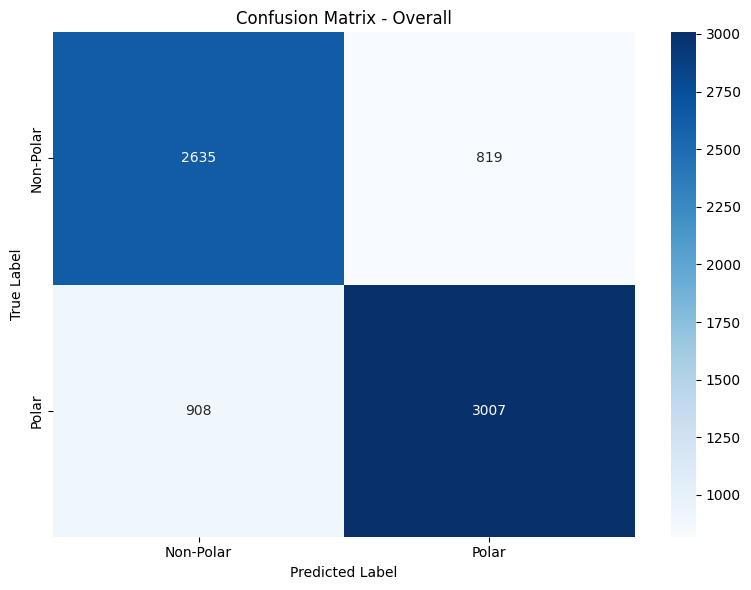


PER-LANGUAGE PERFORMANCE ANALYSIS

Detailed Per-Language Metrics:
Language  Samples  Accuracy  F1_Macro  F1_NonPolar  F1_Polar
     zho      436  0.809633  0.809584     0.806527  0.812641
     ben      314  0.786624  0.780367     0.817439  0.743295
     swa      697  0.781923  0.780126     0.800000  0.760252
     nep      194  0.778351  0.778297     0.774869  0.781726
     mya      289  0.778547  0.770840     0.728814  0.812865
     tel      231  0.779221  0.770104     0.724324  0.815884
     fas      337  0.801187  0.726623     0.583851  0.869396
     arb      297  0.730640  0.718777     0.776536  0.661017
     hin      266  0.898496  0.707228     0.470588  0.943867
     eng      328  0.731707  0.691821     0.802691  0.580952
     hau      370  0.908108  0.681970     0.950147  0.413793
     pan      154  0.668831  0.662556     0.708571  0.616541
     rus      309  0.731392  0.651426     0.818381  0.484472
     ita      351  0.689459  0.643522     0.771488  0.515556
     deu      331 

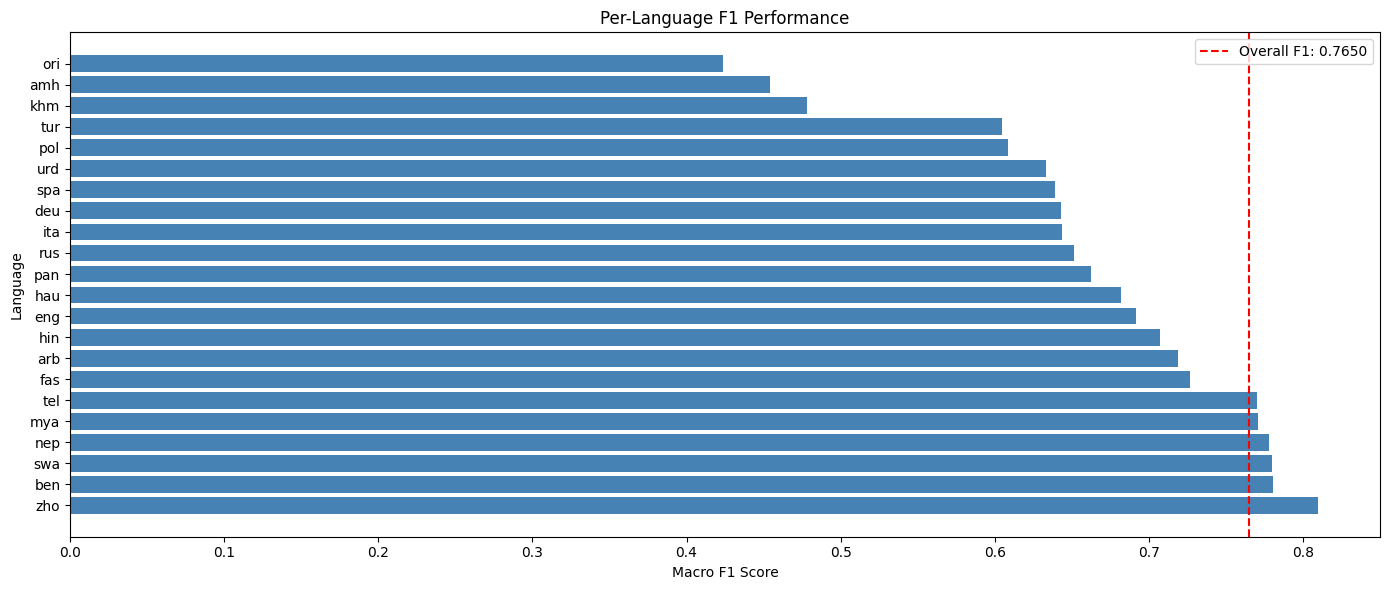

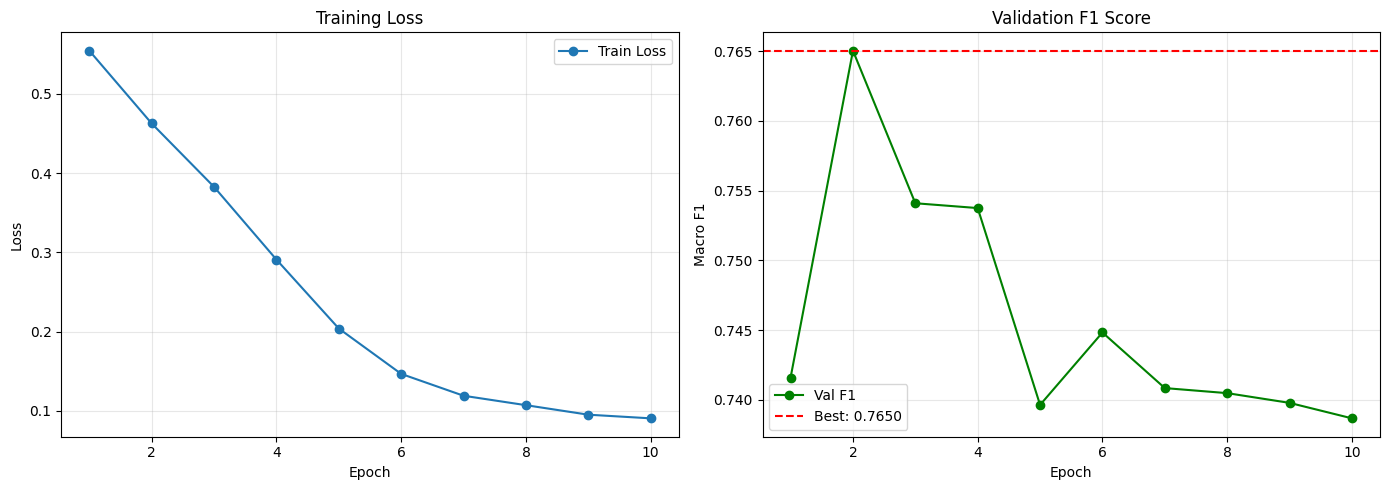


ANALYSIS COMPLETE


In [ ]:
"""
BiLSTM + Attention with Language Embeddings
"""

# =========================
# 0) SETUP & INSTALLS
# =========================
!pip -q install -U transformers scikit-learn pandas matplotlib seaborn

#added to prevent colab errors
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"

import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

#run on colab GPU
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# =========================
# 1) DATA LOADING
# =========================
ZIP_PATH = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Upload {ZIP_PATH} to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print(f"\nFound {len(train_files)} language CSV files")

# =========================
# 2) COLUMN INFERENCE & LOADING
# =========================
TEXT_CANDIDATES = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = {c.lower(): c for c in df.columns}
    text_col = next((cols[c] for c in TEXT_CANDIDATES if c in cols), None)
    label_col = next((cols[c] for c in LABEL_CANDIDATES if c in cols), None)
    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(f"Column inference failed for {os.path.basename(path)}")

    out = pd.DataFrame({
        "text": df[text_col].astype(str),
        "label": pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1),
        "lang": os.path.splitext(os.path.basename(path))[0],
    })
    return out.dropna(subset=["text"]).reset_index(drop=True)

# Load all data
dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

# Language statistics
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total examples: {len(full_df):,}")
print(f"Total languages: {full_df['lang'].nunique()}")
print(f"Label distribution: {full_df['label'].value_counts().to_dict()}")
print("\nPer-language breakdown:")
lang_stats = full_df.groupby('lang').agg({
    'text': 'count',
    'label': lambda x: f"{(x==1).sum()}/{len(x)}"
}).rename(columns={'text': 'count', 'label': 'pos/total'})
print(lang_stats.sort_values('count', ascending=False))

# =========================
# 3) TRAIN/VAL SPLIT (stratified)
# =========================
#stratified split to preserve class balance in val
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    stratify=full_df["label"],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("\n" + "="*60)
print("TRAIN/VAL SPLIT")
print("="*60)
print(f"Train: {len(train_df):,} | Val: {len(val_df):,}")
print(f"Train labels: {train_df['label'].value_counts().to_dict()}")
print(f"Val labels: {val_df['label'].value_counts().to_dict()}")

# Create language ID mapping
lang2id = {lang: idx for idx, lang in enumerate(sorted(full_df['lang'].unique()))}
id2lang = {idx: lang for lang, idx in lang2id.items()}
print(f"\nLanguage ID mapping created: {len(lang2id)} languages")

# Add language IDs to dataframes
train_df['lang_id'] = train_df['lang'].map(lang2id)
val_df['lang_id'] = val_df['lang'].map(lang2id)

# =========================
# 4) TOKENIZER & DATASET
# =========================
#use mbert tokenizer for multilingual subword ids
TOKENIZER_NAME = "bert-base-multilingual-cased"
MAX_LEN = 128
BATCH_SIZE = 64

print(f"\nLoading tokenizer: {TOKENIZER_NAME}")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token

#add language ids so model can condition on language during encoding
#dataset returns input_ids, attention_mask, lang_id, label
class PolDatasetWithLang(Dataset):
    def __init__(self, texts, labels, lang_ids, tok, max_len):
        self.texts = texts
        self.labels = labels
        self.lang_ids = lang_ids
        self.tok = tok
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        #tokenize to fixed length for batching
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            #return_tensors="pt" adds batch dim -> squeeze(0) gives shape [max_len]
            "input_ids": enc["input_ids"].squeeze(0),
            #attention_mask: 1=real token, 0=padding (used to mask attention)
            "attention_mask": enc["attention_mask"].squeeze(0),
            #lang_id is an integer index for the language of this sample
            "lang_id": torch.tensor(self.lang_ids[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

#build datasets with language ids
train_ds = PolDatasetWithLang(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    train_df["lang_id"].tolist(),
    tokenizer,
    MAX_LEN
)

val_ds = PolDatasetWithLang(
    val_df["text"].tolist(),
    val_df["label"].tolist(),
    val_df["lang_id"].tolist(),
    tokenizer,
    MAX_LEN
)

#dataloaders produce batches with lang_id per example
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# =========================
# 5) MODEL: BiLSTM + ATTENTION + LANGUAGE EMBEDDINGS
# =========================
#bilstm+attn+lang: concatenate word emb with language emb at each timestep
#language embedding gives the model a learnable language signal (like a language token)
class BiLSTMAttnWithLang(nn.Module):
    def __init__(self, vocab_size, pad_id, num_langs, lang_emb_dim=16,
                 embed_dim=128, hidden=128, attn_dim=128, dropout=0.3, num_classes=2):
        super().__init__()

        # Embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        #lang_embedding maps lang_id -> dense vector (learned per language)
        self.lang_embedding = nn.Embedding(num_langs, lang_emb_dim)

        # BiLSTM
        #lstm input is word emb + lang emb, so input_size = embed_dim + lang_emb_dim
        self.lstm = nn.LSTM(
            embed_dim + lang_emb_dim,
            hidden,
            batch_first=True,
            bidirectional=True
        )

        #attention: score each timestep then softmax over time
        self.attn_W = nn.Linear(hidden * 2, attn_dim)
        self.attn_v = nn.Linear(attn_dim, 1, bias=False)

        #classifier uses context vector (size 2*hidden because BiLSTM)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask, lang_ids):
        # Word embeddings
        x = self.embedding(input_ids)  # (B, T, E)

        # Language embeddings (broadcast across sequence)
        lang_emb = self.lang_embedding(lang_ids).unsqueeze(1)  # (B, 1, L)
        lang_emb = lang_emb.expand(-1, x.size(1), -1)  # (B, T, L)

        # Concatenate word + language embeddings
        x = torch.cat([x, lang_emb], dim=-1)  # (B, T, E+L)

        # BiLSTM
        H, _ = self.lstm(x)  # (B, T, 2H)

        # Attention mechanism
        scores = self.attn_v(torch.tanh(self.attn_W(H))).squeeze(-1)  # (B, T)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1)  # (B, T)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)  # (B, 2H)

        # Classification
        context = self.dropout(context)
        return self.fc(context)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

#initialize model
model = BiLSTMAttnWithLang(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    num_langs=len(lang2id),
    lang_emb_dim=16,
    embed_dim=128,
    hidden=128,
    attn_dim=128,
    dropout=0.3,
    num_classes=2
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# =========================
# 6) TRAINING SETUP
# =========================
#cross entropy loss for binary classification (logits over 2 classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_metrics(model, loader, return_details=False):
    #Evaluate model and return per-language details
    model.eval()
    all_preds, all_labels, all_langs = [], [], []

    with torch.no_grad():
        for batch in loader:
            #forward pass includes lang_id so model can condition on language
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["lang_id"].to(device)
            )
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(batch["label"].numpy().tolist())
            all_langs.extend(batch["lang_id"].numpy().tolist())

    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    if return_details:
        return macro_f1, all_labels, all_preds, all_langs
    return macro_f1

# =========================
# 7) TRAINING LOOP
# =========================
EPOCHS = 10
best_f1 = -1.0
best_state = None
history = {'train_loss': [], 'val_f1': []}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

#train for fixed epochs, track val macro-f1, keep best checkpoint in memory
for epoch in range(1, EPOCHS + 1):
    model.train()
    #total_loss used to report mean training loss per epoch
    total_loss = 0.0

    #tqdm progress bar over train batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()

        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["lang_id"].to(device)
        )
        loss = criterion(logits, batch["label"].to(device))
        loss.backward()
        #clip gradients to avoid exploding gradients in rnn training
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Evaluate
    val_f1 = eval_metrics(model, val_loader)
    #average batch loss across epoch (for learning curve)
    avg_loss = total_loss / len(train_loader)

    history['train_loss'].append(avg_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch}/{EPOCHS} | train_loss={avg_loss:.4f} | val_macro_f1={val_f1:.4f}")

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")

print("\n" + "="*60)
print(f"TRAINING COMPLETE - Best Val F1: {best_f1:.4f}")
print("="*60)

# =========================
# 8) FINAL EVALUATION
# =========================
# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)

val_f1, y_true, y_pred, y_langs = eval_metrics(model, val_loader, return_details=True)

print("\n" + "="*60)
print("OVERALL VALIDATION RESULTS")
print("="*60)
print(f"Macro F1: {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4, target_names=['Non-Polar', 'Polar']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Polar', 'Polar'],
            yticklabels=['Non-Polar', 'Polar'])
plt.title('Confusion Matrix - Overall')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# =========================
# 9) PER-LANGUAGE ANALYSIS
# =========================
print("\n" + "="*60)
print("PER-LANGUAGE PERFORMANCE ANALYSIS")
print("="*60)

#group predictions by language to compute per-language metrics
lang_results = defaultdict(lambda: {'y_true': [], 'y_pred': []})

#map each example back to its language name using id2lang
for true, pred, lang_id in zip(y_true, y_pred, y_langs):
    lang = id2lang[lang_id]
    lang_results[lang]['y_true'].append(true)
    lang_results[lang]['y_pred'].append(pred)

# Calculate per-language metrics
per_lang_metrics = []
for lang in sorted(lang_results.keys()):
    yt = lang_results[lang]['y_true']
    yp = lang_results[lang]['y_pred']

    if len(yt) > 0:
        f1_macro = f1_score(yt, yp, average='macro')
        f1_pos = f1_score(yt, yp, pos_label=1)
        f1_neg = f1_score(yt, yp, pos_label=0)
        accuracy = np.mean(np.array(yt) == np.array(yp))

        per_lang_metrics.append({
            'Language': lang,
            'Samples': len(yt),
            'Accuracy': accuracy,
            'F1_Macro': f1_macro,
            'F1_NonPolar': f1_neg,
            'F1_Polar': f1_pos
        })

# Display results
results_df = pd.DataFrame(per_lang_metrics)
#sort languages by macro f1 to see best/worst
results_df = results_df.sort_values('F1_Macro', ascending=False)

print("\nDetailed Per-Language Metrics:")
print(results_df.to_string(index=False))

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Mean F1 (macro): {results_df['F1_Macro'].mean():.4f} ± {results_df['F1_Macro'].std():.4f}")
print(f"Median F1 (macro): {results_df['F1_Macro'].median():.4f}")
print(f"Best language: {results_df.iloc[0]['Language']} (F1: {results_df.iloc[0]['F1_Macro']:.4f})")
print(f"Worst language: {results_df.iloc[-1]['Language']} (F1: {results_df.iloc[-1]['F1_Macro']:.4f})")

# Visualization: F1 scores by language
plt.figure(figsize=(14, 6))
plt.barh(results_df['Language'], results_df['F1_Macro'], color='steelblue')
plt.axvline(x=val_f1, color='red', linestyle='--', label=f'Overall F1: {val_f1:.4f}')
plt.xlabel('Macro F1 Score')
plt.ylabel('Language')
plt.title('Per-Language F1 Performance')
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 10) TRAINING HISTORY VISUALIZATION
# =========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, EPOCHS+1), history['train_loss'], marker='o', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, EPOCHS+1), history['val_f1'], marker='o', color='green', label='Val F1')
ax2.axhline(y=best_f1, color='red', linestyle='--', label=f'Best: {best_f1:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro F1')
ax2.set_title('Validation F1 Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

## Precision-recall curve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 35.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

Found 22 language CSV files

DATASET STATISTICS
Total examples: 73,681
Total languages: 22
Label distribution: {1: 39145, 0: 34536}

TRAIN/VAL SPLIT
Train: 66,312 | Val: 7,369
Train labels: {1: 35230, 0: 31082}
Val labels: {1: 3915, 0: 3454}

Loading tokenizer: bert-base-mul

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Train batches: 1037 | Val batches: 116

Using device: cuda

STARTING TRAINING


Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.5545 | val_macro_f1=0.7457
  ✓ New best model saved! (F1: 0.7457)


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=0.4635 | val_macro_f1=0.7542
  ✓ New best model saved! (F1: 0.7542)


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=0.3819 | val_macro_f1=0.7588
  ✓ New best model saved! (F1: 0.7588)


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.2901 | val_macro_f1=0.7565


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.2107 | val_macro_f1=0.7546


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.1576 | val_macro_f1=0.7507


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.1256 | val_macro_f1=0.7433


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.1108 | val_macro_f1=0.7421


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.1009 | val_macro_f1=0.7461


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.0964 | val_macro_f1=0.7427

TRAINING COMPLETE - Best Val F1: 0.7588


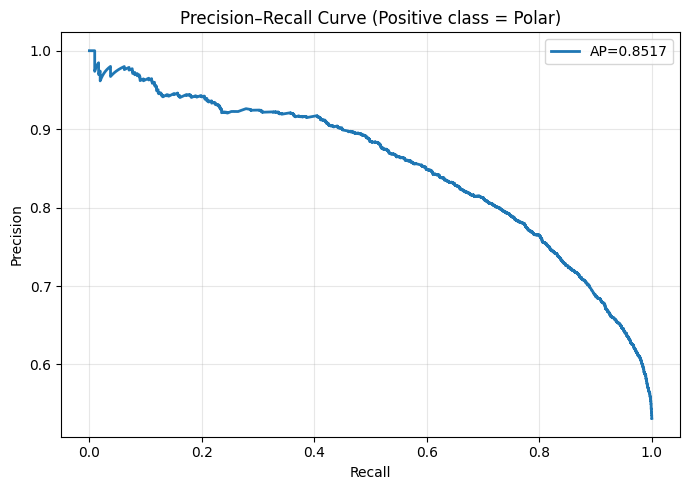


VALIDATION REPORT (threshold=0.5)
              precision    recall  f1-score   support

   Non-Polar     0.7535    0.7264    0.7397      3454
       Polar     0.7660    0.7903    0.7780      3915

    accuracy                         0.7603      7369
   macro avg     0.7597    0.7583    0.7588      7369
weighted avg     0.7601    0.7603    0.7600      7369



In [1]:
# -*- coding: utf-8 -*-

"""
BiLSTM + Attention with Language Embeddings
ONLY: Precision–Recall curve (no other figures)

Also fixes the Colab/PyTorch DataLoader worker shutdown warning:
AssertionError: can only test a child process
by using num_workers=0 (recommended in notebooks) and disabling persistent workers.
"""

# =========================
# 0) SETUP & INSTALLS
# =========================
!pip -q install -U transformers scikit-learn pandas matplotlib

import os
# prevent some torch compile/dynamo issues in Colab
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"

import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm.auto import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# =========================
# 1) DATA LOADING
# =========================
ZIP_PATH = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Upload {ZIP_PATH} to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print(f"\nFound {len(train_files)} language CSV files")

# =========================
# 2) COLUMN INFERENCE & LOADING
# =========================
TEXT_CANDIDATES = ["text", "sentence", "content", "tweet", "post", "comment"]
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]

def infer_columns(df):
    # map lowercase -> original to handle capitalization differences
    cols = {c.lower(): c for c in df.columns}
    text_col = next((cols[c] for c in TEXT_CANDIDATES if c in cols), None)
    label_col = next((cols[c] for c in LABEL_CANDIDATES if c in cols), None)
    return text_col, label_col

def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(f"Column inference failed for {os.path.basename(path)}")

    out = pd.DataFrame({
        "text": df[text_col].astype(str),
        # enforce 0/1 integer labels
        "label": pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1),
        # language name from filename (e.g., en.csv -> en)
        "lang": os.path.splitext(os.path.basename(path))[0],
    })
    return out.dropna(subset=["text"]).reset_index(drop=True)

# load and merge all languages, then shuffle once for reproducibility
dfs = [load_csv_labeled(p) for p in train_files]
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Total examples: {len(full_df):,}")
print(f"Total languages: {full_df['lang'].nunique()}")
print(f"Label distribution: {full_df['label'].value_counts().to_dict()}")

# =========================
# 3) TRAIN/VAL SPLIT (stratified)
# =========================
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    stratify=full_df["label"],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# map language -> id so we can learn language embeddings
lang2id = {lang: idx for idx, lang in enumerate(sorted(full_df["lang"].unique()))}
train_df["lang_id"] = train_df["lang"].map(lang2id)
val_df["lang_id"] = val_df["lang"].map(lang2id)

print("\n" + "=" * 60)
print("TRAIN/VAL SPLIT")
print("=" * 60)
print(f"Train: {len(train_df):,} | Val: {len(val_df):,}")
print(f"Train labels: {train_df['label'].value_counts().to_dict()}")
print(f"Val labels: {val_df['label'].value_counts().to_dict()}")

# =========================
# 4) TOKENIZER & DATASET
# =========================
TOKENIZER_NAME = "bert-base-multilingual-cased"
MAX_LEN = 128
BATCH_SIZE = 64

print(f"\nLoading tokenizer: {TOKENIZER_NAME}")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token

class PolDatasetWithLang(Dataset):
    # returns input_ids, attention_mask, lang_id, label
    def __init__(self, texts, labels, lang_ids, tok, max_len):
        self.texts = texts
        self.labels = labels
        self.lang_ids = lang_ids
        self.tok = tok
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            # squeeze(0) removes the extra batch dim added by return_tensors="pt"
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "lang_id": torch.tensor(self.lang_ids[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = PolDatasetWithLang(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    train_df["lang_id"].tolist(),
    tokenizer,
    MAX_LEN
)
val_ds = PolDatasetWithLang(
    val_df["text"].tolist(),
    val_df["label"].tolist(),
    val_df["lang_id"].tolist(),
    tokenizer,
    MAX_LEN
)

# FIX for the Colab worker shutdown warning:
# In notebook environments, multiprocessing workers can get into a bad state on cell reruns.
# Using num_workers=0 is the most robust and removes the AssertionError spam.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, persistent_workers=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, persistent_workers=False)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# =========================
# 5) MODEL: BiLSTM + ATTENTION + LANGUAGE EMBEDDINGS
# =========================
class BiLSTMAttnWithLang(nn.Module):
    def __init__(self, vocab_size, pad_id, num_langs, lang_emb_dim=16,
                 embed_dim=128, hidden=128, attn_dim=128, dropout=0.3, num_classes=2):
        super().__init__()

        # token embedding table (learned from scratch here)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        # language embedding table: one vector per language id
        self.lang_embedding = nn.Embedding(num_langs, lang_emb_dim)

        # BiLSTM reads concatenated [token_emb || lang_emb] at each timestep
        self.lstm = nn.LSTM(
            embed_dim + lang_emb_dim,
            hidden,
            batch_first=True,
            bidirectional=True
        )

        # attention scoring: (B,T,2H) -> (B,T,attn_dim) -> (B,T,1)
        self.attn_W = nn.Linear(hidden * 2, attn_dim)
        self.attn_v = nn.Linear(attn_dim, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask, lang_ids):
        # token embeddings: (B,T) -> (B,T,E)
        x = self.embedding(input_ids)

        # language embedding: (B,) -> (B,1,L) -> broadcast to (B,T,L)
        lang_emb = self.lang_embedding(lang_ids).unsqueeze(1)
        lang_emb = lang_emb.expand(-1, x.size(1), -1)

        # concatenate: (B,T,E+L)
        x = torch.cat([x, lang_emb], dim=-1)

        # BiLSTM hidden states: (B,T,2H)
        H, _ = self.lstm(x)

        # attention scores per timestep: (B,T)
        scores = self.attn_v(torch.tanh(self.attn_W(H))).squeeze(-1)
        # mask out padding tokens before softmax
        scores = scores.masked_fill(attention_mask == 0, -1e9)

        # attention weights across time: (B,T)
        weights = torch.softmax(scores, dim=1)

        # weighted sum to get context vector: (B,2H)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)

        # logits over classes: (B,2)
        context = self.dropout(context)
        return self.fc(context)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

model = BiLSTMAttnWithLang(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    num_langs=len(lang2id),
    lang_emb_dim=16,
    embed_dim=128,
    hidden=128,
    attn_dim=128,
    dropout=0.3,
    num_classes=2
).to(device)

# =========================
# 6) TRAINING SETUP
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_macro_f1(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["lang_id"].to(device),
            )
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(batch["label"].numpy().tolist())
    return f1_score(all_labels, all_preds, average="macro")

# =========================
# 7) TRAINING LOOP (keeps best checkpoint)
# =========================
EPOCHS = 10
best_f1 = -1.0
best_state = None

print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()

        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["lang_id"].to(device),
        )
        loss = criterion(logits, batch["label"].to(device))
        loss.backward()

        # gradient clipping helps stabilize RNN training
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    val_f1 = eval_macro_f1(model, val_loader)
    avg_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch}/{EPOCHS} | train_loss={avg_loss:.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")

print("\n" + "=" * 60)
print(f"TRAINING COMPLETE - Best Val F1: {best_f1:.4f}")
print("=" * 60)

if best_state is not None:
    model.load_state_dict(best_state)

# =========================
# 8) PRECISION–RECALL CURVE (ONLY FIGURE)
# =========================
# For PR curves we need a continuous score, not hard class predictions.
# We use P(class=1) from softmax(logits) as the score for the positive class (Polar).
model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for batch in val_loader:
        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["lang_id"].to(device),
        )
        # convert logits -> probabilities
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1
        y_score.extend(probs.cpu().numpy().tolist())
        y_true.extend(batch["label"].numpy().tolist())

y_true = np.array(y_true)
y_score = np.array(y_score)

# compute PR points
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# average precision (area under PR curve in sklearn’s definition)
ap = average_precision_score(y_true, y_score)

# plot
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, linewidth=2, label=f"AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Positive class = Polar)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print the standard classification report (text only, no figures)
# This keeps outputs similar to your prior method without adding plots.
y_pred = (y_score >= 0.5).astype(int)
print("\n" + "=" * 60)
print("VALIDATION REPORT (threshold=0.5)")
print("=" * 60)
print(classification_report(y_true, y_pred, digits=4, target_names=["Non-Polar", "Polar"]))


# FastText Embedding

In [ ]:
# =========================
# BiLSTM + Attention with FastText
# Word-Level Tokenization (FastText)
# =========================

# ---- installs
!pip -q install -U scikit-learn gensim

# ---- safety for Colab torch._dynamo issues
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"

import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tqdm.auto import tqdm
import gensim.downloader as api
from collections import Counter

# =========================
# 1) UNZIP DATA
# =========================
ZIP_PATH  = "/content/dev_phase.zip"
UNZIP_DIR = "/content/dev_phase"

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Upload {ZIP_PATH} to Colab.")

if not os.path.exists(UNZIP_DIR):
    !unzip -q {ZIP_PATH} -d {UNZIP_DIR}

SUBTASK1_DIR = os.path.join(UNZIP_DIR, "subtask1")
TRAIN_DIR    = os.path.join(SUBTASK1_DIR, "train")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print("Found train CSVs:", len(train_files))
if len(train_files) == 0:
    raise RuntimeError("No train CSVs found.")

# =========================
# 2) LOAD + INFER COLUMNS
# =========================
TEXT_CANDIDATES  = ["text", "sentence", "content", "tweet", "post", "comment"]
#actual column name used in cvs is "text"
LABEL_CANDIDATES = ["polarization", "label", "labels", "gold", "target", "y"]
#actual column name used in cvs is "polarization"

#infer text/label columns across different csvs
def infer_columns(df):
    cols = {c.lower(): c for c in df.columns}
    text_col  = next((cols[c] for c in TEXT_CANDIDATES  if c in cols), None)
    label_col = next((cols[c] for c in LABEL_CANDIDATES if c in cols), None)
    return text_col, label_col

#load one language cvs
def load_csv_labeled(path):
    df = pd.read_csv(path)
    text_col, label_col = infer_columns(df)
    if text_col is None or label_col is None:
        raise ValueError(f"Column inference failed for {os.path.basename(path)}")
    out = pd.DataFrame({
        "text":  df[text_col].astype(str),
        "label": pd.to_numeric(df[label_col], errors="raise").astype(int).clip(0, 1),
        "lang":  os.path.splitext(os.path.basename(path))[0],
    })
    return out.dropna(subset=["text"]).reset_index(drop=True)

dfs = [load_csv_labeled(p) for p in train_files]
#merge all languages then shuffle once
full_df = pd.concat(dfs, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total examples:", len(full_df))
print("Label dist:", full_df["label"].value_counts().to_dict())
print("Languages:", full_df["lang"].nunique())

# =========================
# 3) TRAIN / VAL SPLIT
# =========================
#stratified split to preserve class balance
train_df, val_df = train_test_split(
    full_df,
    test_size=0.10,
    stratify=full_df["label"],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df))

# =========================
# 4) WORD-LEVEL TOKENIZER
# =========================
#simple word-level tokenizer for fasttext (no subwords)
class WordTokenizer:
    def __init__(self, max_vocab=50000, min_freq=2):
        self.max_vocab = max_vocab
        self.min_freq = min_freq
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.pad_token_id = 0
        self.unk_token_id = 1

    def tokenize(self, text):
        #Simple whitespace + punctuation tokenization
        return text.lower().split()

    def build_vocab(self, texts):
        #build vocab from training data only to avoid leakage
        word_counts = Counter()
        for text in texts:
            word_counts.update(self.tokenize(text))

        #filter by frequency and limit vocab size
        words = [w for w, c in word_counts.most_common(self.max_vocab)
                 if c >= self.min_freq]

        #add to vocabulary
        for word in words:
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")
        return self

    def encode(self, text, max_length=128):
        #encode text to fixed length ids + attention mask
        #unknown words mapped to <unk>
        tokens = self.tokenize(text)[:max_length]
        ids = [self.word2idx.get(w, self.unk_token_id) for w in tokens]

        # Pad to max_length
        padding_length = max_length - len(ids)
        ids = ids + [self.pad_token_id] * padding_length

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1] * len(tokens) + [0] * padding_length
        attention_mask = attention_mask[:max_length]

        return {
            "input_ids": ids,
            "attention_mask": attention_mask
        }

    def get_vocab(self):
        #return vocab dict for compatibility
        return self.word2idx

    @property
    def vocab_size(self):
        return len(self.word2idx)

# Build tokenizer
MAX_LEN = 128
BATCH_SIZE = 64

print("\nBuilding vocabulary...")
tokenizer = WordTokenizer(max_vocab=50000, min_freq=2)
tokenizer.build_vocab(train_df["text"].tolist())

# =========================
# 5) DATASET
# =========================
#dataset uses word ids instead of subword tokenizer ids
class PolDataset(Dataset):
    def __init__(self, texts, labels, tok, max_len):
        self.texts = texts
        self.labels = labels
        self.tok = tok
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        #convert word ids and attention mask to tensors
        enc = self.tok.encode(self.texts[idx], max_length=self.max_len)
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = PolDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = PolDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# =========================
# 6) LOAD FASTTEXT & BUILD EMBEDDING MATRIX
# =========================
print("\n" + "="*50)
print("Loading FastText model (this may take a few minutes)...")
print("="*50)
ft_model = api.load("fasttext-wiki-news-subwords-300")

#initialize embedding matrix
EMB_DIM = 300
embedding_matrix = np.random.normal(
    scale=0.6, size=(tokenizer.vocab_size, EMB_DIM)
).astype("float32")

#fill in known tokens
found = 0
for word, idx in tokenizer.get_vocab().items():
    if word in ["<PAD>", "<UNK>"]:
        continue  #keep random for special tokens
    try:
        embedding_matrix[idx] = ft_model[word]
        found += 1
    except KeyError:
        pass  #keep random initialization

print(f"Initialized {found}/{tokenizer.vocab_size} tokens with FastText vectors")
print(f"Coverage: {100 * found / tokenizer.vocab_size:.2f}%\n")

# =========================
# 7) BiLSTM + ATTENTION MODEL
# =========================
#bilstm+attn with frozen fasttext embeddings
class BiLSTMAttnClassifier(nn.Module):
    def __init__(self, vocab_size, pad_id, embedding_matrix, hidden=128, attn_dim=128, dropout=0.3, num_classes=2):
        super().__init__()
        embed_dim = embedding_matrix.shape[1]  #should be 300
        #embedding initialized from fasttext
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False   # freeze embeddings

        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.attn_W = nn.Linear(hidden * 2, attn_dim)
        self.attn_v = nn.Linear(attn_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        #attention weights highlight informative words in the sentence
        x = self.embedding(input_ids)                 # (B,T,E)
        H, _ = self.lstm(x)                           # (B,T,2H)
        scores = self.attn_v(torch.tanh(self.attn_W(H))).squeeze(-1)  # (B,T)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1)        # (B,T)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)  # (B,2H)
        context = self.dropout(context)
        return self.fc(context)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

model = BiLSTMAttnClassifier(
    vocab_size=tokenizer.vocab_size,
    pad_id=tokenizer.pad_token_id,
    embedding_matrix=embedding_matrix,
    hidden=128,
    attn_dim=128,
    dropout=0.3,
    num_classes=2
).to(device)

# =========================
# 8) TRAINING SETUP
# =========================
#cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_macro_f1(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds = torch.argmax(logits, dim=1)
            ys.extend(batch["label"].numpy().tolist())
            ps.extend(preds.cpu().numpy().tolist())
    return f1_score(ys, ps, average="macro"), ys, ps

# =========================
# 9) TRAIN + EVAL
# =========================
EPOCHS = 10
best_f1, best_state = -1.0, None

print("="*50)
print("Starting Training")
print("="*50)

#train for fixed epochs and keep best model by val macro-f1
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True):
        optimizer.zero_grad()
        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        loss = criterion(logits, batch["label"].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    val_f1, _, _ = eval_macro_f1(model, val_loader)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={total_loss/len(train_loader):.4f} | val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        #store best model in memory
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\n" + "="*50)
print(f"Best VAL Macro F1: {best_f1:.4f}")
print("="*50)

# restore best + report
if best_state is not None:
    model.load_state_dict(best_state)

val_f1, y_true, y_pred = eval_macro_f1(model, val_loader)
print(f"\nFINAL VAL Macro F1: {val_f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))

Found train CSVs: 22
Total examples: 73681
Label dist: {1: 39145, 0: 34536}
Languages: 22
Train: 66312 Val: 7369

Building vocabulary...
Vocabulary size: 50002

Loading FastText model (this may take a few minutes)...
Initialized 14347/50002 tokens with FastText vectors
Coverage: 28.69%

Using device: cuda

Starting Training


Epoch 1/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=0.6070 | val_macro_f1=0.6900


Epoch 2/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=0.5395 | val_macro_f1=0.7142


Epoch 3/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=0.4758 | val_macro_f1=0.7121


Epoch 4/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.4066 | val_macro_f1=0.7192


Epoch 5/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.3403 | val_macro_f1=0.7189


Epoch 6/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.2846 | val_macro_f1=0.7077


Epoch 7/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.2453 | val_macro_f1=0.6951


Epoch 8/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.2195 | val_macro_f1=0.7059


Epoch 9/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.2014 | val_macro_f1=0.7066


Epoch 10/10:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.1889 | val_macro_f1=0.7040

Best VAL Macro F1: 0.7192

FINAL VAL Macro F1: 0.7192

              precision    recall  f1-score   support

           0     0.7033    0.6980    0.7007      3454
           1     0.7353    0.7402    0.7378      3915

    accuracy                         0.7205      7369
   macro avg     0.7193    0.7191    0.7192      7369
weighted avg     0.7203    0.7205    0.7204      7369

